# Lab Three - Jupiter Data Merging with Jupyter

## *Merging Magnetic Field, Location, and  Error Propagation from the Recent Juno Mission*

In this lab we learn how to download NASA planetary science data from the planetary data system (PDS). Additionally we will handle missing / incomplete data analysis and error calculations.

You will learn how to: 

- Download multiple data types with more complicated datetime format.
- Format datetime objects axis on plots. 
- Deal with missing data.
- Learn how to design and import your own modules / packages.
- Deal with vector data (rudimentary vector calculations). 

By the end of this lab you should be able to: read in complicated data from non CSV formats and deal with missing data.

Additional materials for reading: Many of the functions have extremely useful help guides online - see: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reindex.html and https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html#pandas.DataFrame.resample



## *Review of Lab 2 & the assignments*


### Part A: Discussion on HW 3

A lot of you noticed that the ocean temperatures were rising slower than land temperatures:

- This is not primarily due to location of emission sources, especially when you are calculating global averages like this - instead the main rationale is the heat capacity of oceans vs land masses. This means that temperature changes occur slower in oceans than they would on land. For example - water has a heat capacity of 4.18 J/gC, while sand (quartz) ~ 0.83 J/gC and soil has ~ 0.8 J/gC. This also means it takes longer to cool down. 

- This can be a good thing - oceans help regulate temperatures - but it can also mean effects are not immediately seen and that there are time lags. 

- 2019 is officially the second warmest year on record since 1880, second only to 2016 with the last six warmest years on record taking place since 2010.

- The previous decade, 2010-2019 was the hottest decade on record. 

- Keep in mind - as with any global temperature rating, specific locations can experience a wide variety compared to the average. Look at here for some examples of global maps and discussion of current climate temperature trends. 
    - https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature
    - https://www.ncei.noaa.gov/news/global-climate-201712
    - https://www.nasa.gov/press-release/long-term-warming-trend-continued-in-2017-nasa-noaa
    - https://www.noaa.gov/news/2019-was-2nd-hottest-year-on-record-for-earth-say-noaa-nasa
  
<img src="./Images/globalAverages_Diff.png" alt="Drawing" style="width: 700px;"/>

----




### Part B: Discussion on HW 4

Last time we learned how to deal with non-pandas formatted data such as numpy ndarrays and dictionaries. You reviewed the Audobon's winter count bird species migration data in your lab assignments. The Audobon Society collected this data to predict and observe how climate change culd affect the ranges of 500+ North American bird species. Using trends in the past and future climatic predictions (recognized greenhouse gas emissions scenarios) they mapped possible ranges into 2020, 2050, and 2080. 

Resources: 

- [Interactive Summary](http://climate.audubon.org/article/audubon-report-glance)

- Full Texts of Report:
    1. [Audubon Climate Report](http://climate.audubon.org/sites/default/files/NAS_EXTBIRD_V1.3_9.2.15%20lb.pdf)
    2. [Landscape Conservation Cooperatives Report and Methods](http://climate.audubon.org/sites/default/files/Audubon-USFWS%20LCC%20Climate%20Change%20FINAL%201.1.pdf)


According to the report - "Of the 588 North American bird species Audubon studied, more than half are likely to be in trouble. Our models indicate that 314 species will lose more than 50 percent of their current climatic range by 2080."

### You can check out the Michigan bird species [here](http://climate.audubon.org/geographical-search/michigan). 




### Pick a bird from the Michigan region at the above link and observe the predicted range. What are some of the differences in the data presentation from what we observed in the lab 3 report?





Image Source: Audobon Society Climate Report - climate.audobon.org

<img src="./Images/ExamplePineSiskinMap.png" alt="Drawing" style="width: 700px;"/>

----
### After lab, for fun, see [this link](https://cornelllabpgstore.com/what-bird-are-you-most-like-all-outcomes/).

# *Part 1 - Reading in Data from the NASA Planetary Data System & Using External Modules*


The goal in this lab will be to analyze data from the Juno mission to Jupiter. Spacecraft missions collect multiple streams of data, e.g, magnetic field measurements, spacecraft position, particle flux data etc. In this lab we will look at both spacecraft position and at magnetic field data. The video below is a brief introduction to the magnetic field investigation of the Juno mission.


<video controls src="./Images/12296_Juno_Magnetometer_appletv.m4v" />

To show the video in the cell above, we used markdown language to source the video from file. 

One can also use the IPython built-in display module like this:

```
from IPython.display import Video
Video("path_to_video/video_filename.mp4")
```
    
If the above video does not work, use the link below:

https://www.youtube.com/watch?v=ITPizr7Pqgg

In [1]:
import numpy as np                            #for handling numbers w/ precision
import pandas as pd                           #for handling dataframes
import matplotlib.pyplot as plt               #for plotting of datasets
import datetime as dt                         #Importing the package datetime for 
                                              #datetime manipulation
import matplotlib.dates as mdt                #for manipulation of dates in matplotlib
import matplotlib.image as mpimg              #For manipulation of img files
                                              #in plotting environments
    
import importlib                              #NEW IN THIS LAB - for reimporting 
                                              #libaries / packages

from matplotlib.ticker import MultipleLocator #NEW IN THIS LAB - for better axis labeling
from matplotlib.ticker import FuncFormatter                

import externalfunctions as extfunc           #NEW IN THIS LAB - this is a package written
                                              #by A. Azari - we will take a look at what's in
                                              #this module in a bit

%matplotlib inline
#setting up Jupyter environment so plots will be placed in the notebook

## Looking at PDS Formatted Data

Let's take a look at where we will be pulling our data from - go ahead and look at

https://pds-ppi.igpp.ucla.edu/search/view/?f=yes&id=pds://PPI/JNO-J-3-FGM-CAL-V1.0/DATA/JUPITER/SS/PERI-17

If you notice in the link this is taking us the to Jupiter Data from Juno of something called FGM or the Fluxgate Magnetometer. The output is a vector which can be accessed in different coordinate systems. This is the SS part of the hyperlink address standing for Sun-State. This coordinate system is defined by the NASA PDS sytems as:

- The X-axis lies along the vector from Jupiter toward the sun and is taken to be positive toward the Sun.
- The Jupiter orbital velocity vector is the second vector used to define the coordinate system; the y axis lies in the plane determined by the Jupiter-Sun vector and the velocity vector and is orthogonal to the x axis (very nearly the negative of the velocity vector). 
- The vector cross product of x and y yields a vector z parallel to the northward (upward) normal of the orbit plane of Jupiter. 

You will notice the PDS data files have DOY format in their naming system as well as time resolution information, either best, 1 second, or 1 minute. 

FYI - you can see conversion DOY and Month/Day format with this link https://www.esrl.noaa.gov/gmd/grad/neubrew/Calendar.jsp

### What can you observe about the magnetic field data from the file names around DOY 355?

This used to be a legit question, because DOY 355 was not there. Now it is there. I should remake this lab with a different missing day.

-

-

-

-











## Downloading PDS Formatted Data

Similar to before we will be writing a function to download our files as we would like to do this a few times, a function is useful. Go ahead and look at the files in your Data/FGM folder. These ARE text files but the extension is a bit tricky, you might have to open them using a text editor or in Anaconda. Then run the function below and take a look at what it imported.

In [2]:
def read_FGM(year, day_of_year):
    '''
    Function to read in Juno Flux Gate Magnetometer data. Is essentially a wrapper
    for read CSV and then manipulation of datetime objects. 
    
    Inputs are year and DOY as a string. 
    
    Output is a read file object of FGM data. 
    '''
    
    #this makes sense to have defined here - rather than in the body of the actual 
    #code because this means then that this is a localized variable that you can only access
    #in the function itself. 
    
    #define column names
    col_names = ['YEAR', 'DOY', 'HOUR', 'MIN', 'SEC', 'MSEC', 'DEC_DAY', 'B_X', 'B_Y', 
                'B_Z', 'OUTBOARD_B_J2000', 'POS_X', 'POS_Y', 'POS_Z']

    data = pd.read_csv('./Data/FGM/fgm_jno_l3_{}{}ss_r1s_v01.sts'.format(year, day_of_year), 
                   header = 114, index_col = False, names = col_names, sep = '\s+')
    
    return(data)

Now that we have defined our own function, the notebook can "see" it, and it becomes part of the namespace for this session. Use `help(read_FGM)` (note this is similar to `read_FGM?` ) to see what information our function has. 

In [3]:
help(read_FGM)

Help on function read_FGM in module __main__:

read_FGM(year, day_of_year)
    Function to read in Juno Flux Gate Magnetometer data. Is essentially a wrapper
    for read CSV and then manipulation of datetime objects. 
    
    Inputs are year and DOY as a string. 
    
    Output is a read file object of FGM data.



In [4]:
year_val = '2018' 
doy_val  = '354'

example_data = read_FGM(year_val, doy_val)

#in this section below go ahead and check to see if it imported what the file 
#actually looked like correctly - look at both some columns and some rows



#WRITE CODE BELOW


example_data.tail()











,YEAR,DOY,HOUR,MIN,SEC,MSEC,DEC_DAY,B_X,B_Y,B_Z,OUTBOARD_B_J2000,POS_X,POS_Y,POS_Z
86395,2018,354,23,59,55,506,354.999948,-36.26,-27.39,-45.88,0.0,-1083926.165,-429531.418,143793.978
86396,2018,354,23,59,56,506,354.999960,-36.31,-27.54,-45.77,0.0,-1083913.983,-429525.753,143795.983
86397,2018,354,23,59,57,506,354.999971,-36.29,-27.47,-45.80,0.0,-1083901.801,-429520.088,143797.987
86398,2018,354,23,59,58,506,354.999983,-36.31,-27.48,-45.67,0.0,-1083889.619,-429514.423,143799.992
86399,2018,354,23,59,59,506,354.999994,-36.33,-27.57,-45.69,0.0,-1083877.437,-429508.758,143801.997


# *Part 2 - Using Self Written Modules*

We could just keep writing functions to import files.

But! We still want to look at JunoCam data! In Lab 3 we have that function but rather than copy and paste this in, maybe instead we could just have 1 file that we have the functions defined in it...

Remember the externalfunction import command we ran at the beggining of the lab? Let's see what that was...

## *Part 2. A - Importing Self Written Modules*

In [5]:
#let's see what we imported 

help(extfunc)



Help on module externalfunctions:

NAME
    externalfunctions - externalfunctions.py

DESCRIPTION
    Comment Block for external modules should have: 
    
    Name and Date: 
    - Written on 1/29/2018 for CLaSP 405 by Lab TA A. Azari. 
    
    Purpose:
    - To create a module with helpful reading file functions and 
    magnetic field data analysis for Lab 4.

FUNCTIONS
    add_quadrature(X, Y, Z)
        Calculates a quadrature sum of three values. 
        Formula as np.sqrt(x^2 + y^2 + z^2)
        Useful when calculating the  magnitude of X, Y, Z vector components. 
        
        Inputs:
        - X, array or single value (numpy etc).
        - Y, array or single value (numpy etc).
        - Z, array or single value (numpy etc).
        
        Outputs:
        - magnitude, array or single value (numpy etc) of magnitude of components.
    
    convert_jupiter_r(columns)
        Takes in a dataframe subset and converts
        into radii of Jupiter by creating new columns.
 

### Question for you!  

### Take a look at the actual external function file in the Jupyter environment. Find the read_FGM function before running the following cell. Think about how Jupyter is interactive with the external function file. Can you explain in words how the read_FGM is being used?

## *Part 2. B. Using and Re-importing Modules*

If you are writing your own modules / packages it can be useful to reload or reimport
the files. Why?

What if you change the external module, and then need to use it. Jupyter/IPython will NOT recognize that it has been changed. You must tell it yourself. 

This is important. When you are writing your code and wondering "I just changed this package! Why is it not recongizing it!" it is most likely needing a reload.

In [6]:
#let's say we had a change in the externalfunction module - say we had an error that then
#we fixed and needed to import more image files. 

#The command is as follows
importlib.reload(extfunc) 



<module 'externalfunctions' from '/Users/adshane/CLASP 423/Lab 3 - March 3/externalfunctions.py'>

In [7]:
#now lets go ahead and run the file reader for the mag field data using this command

#normally I am against numbers as variable names like this. However since 
#this is informative, not just listing the first instance, it's ok
mag354 = extfunc.read_FGM(year_val, doy_val)




### Question for you!  

### Is this the same formatted data that we imported above? Or is the function in externalModule different?

-

-

-


-

In [8]:
#WRITE CODE HERE TO LOOK AT THE mag354 data
mag354.head(10)

,DATETIME,MSEC,B_X,B_Y,B_Z,POS_X,POS_Y,POS_Z
DATETIME,,,,,,,,
2018-12-20 00:00:00,2018 354 0 0 0,911,-1.33,0.81,-5.89,-1932735.650,-837017.696,-44865.419
2018-12-20 00:00:01,2018 354 0 0 1,473,-1.38,0.77,-5.90,-1932731.022,-837015.414,-44864.169
2018-12-20 00:00:02,2018 354 0 0 2,473,-1.38,0.81,-5.87,-1932722.793,-837011.357,-44861.948
2018-12-20 00:00:03,2018 354 0 0 3,473,-1.32,0.89,-5.89,-1932714.565,-837007.300,-44859.726
2018-12-20 00:00:04,2018 354 0 0 4,473,-1.33,0.96,-5.86,-1932706.337,-837003.242,-44857.505
2018-12-20 00:00:05,2018 354 0 0 5,473,-1.33,1.01,-5.66,-1932698.109,-836999.185,-44855.283
2018-12-20 00:00:06,2018 354 0 0 6,473,-1.34,1.07,-5.46,-1932689.880,-836995.128,-44853.062
2018-12-20 00:00:07,2018 354 0 0 7,473,-1.34,1.18,-5.48,-1932681.652,-836991.071,-44850.840
2018-12-20 00:00:08,2018 354 0 0 8,473,-1.18,1.27,-5.38,-1932673.423,-836987.013,-44848.619


# *Part 3 - Dealing with Missing Data*

How are we going to deal with having data for DOY 354 and 356 and not 355? 

First let's combine these dataframes.



In [9]:
#Let's read in for the next day we have - remember how we were missing DOY 355?
year_value = '2018'
doy_value = '356'


#normally I am against numbers as variable names like this, however since 
#this is informative, not just listing the first instance, it's ok
mag356 = extfunc.read_FGM(year_value, doy_value)




### Question for you:

Some good data checks are to check type, head, tail, and also length of your imported data frame. Go ahead and in the cell below type in `len(dataframe)` to check `mag354` and `mag356`. Are they the same length? Are they the same length as 1 second over 24 hours of data? (24 x 60 x 60).

In [10]:
#check the length in this cell
print(len(mag354))
print(len(mag356))

print(mag354.shape)
print(mag356.shape)

86400
85795
(86400, 8)
(85795, 8)


### What could be happening here?

-

-


-


-

-

In [11]:
#and now for combining
data_FGM = pd.concat([mag354, mag356])



print(data_FGM)





                              DATETIME  MSEC    B_X    B_Y    B_Z  \
DATETIME                                                            
2018-12-20 00:00:00     2018 354 0 0 0   911  -1.33   0.81  -5.89   
2018-12-20 00:00:01     2018 354 0 0 1   473  -1.38   0.77  -5.90   
2018-12-20 00:00:02     2018 354 0 0 2   473  -1.38   0.81  -5.87   
2018-12-20 00:00:03     2018 354 0 0 3   473  -1.32   0.89  -5.89   
2018-12-20 00:00:04     2018 354 0 0 4   473  -1.33   0.96  -5.86   
...                                ...   ...    ...    ...    ...   
2018-12-22 23:59:55  2018 356 23 59 55   525  52.69  29.05  34.91   
2018-12-22 23:59:56  2018 356 23 59 56   525  52.72  29.01  34.96   
2018-12-22 23:59:57  2018 356 23 59 57   525  52.72  29.00  34.95   
2018-12-22 23:59:58  2018 356 23 59 58   525  52.70  29.01  34.92   
2018-12-22 23:59:59  2018 356 23 59 59   525  52.71  29.01  34.93   

                           POS_X       POS_Y        POS_Z  
DATETIME                                  

## *Part 3. A Missing Data and Plotting - First Look*

Our magnetic field data is missing December 21 - or DOY 355, it's also missing random dates within the dataframe, but there's no clear way to tell which ones! We also have spacecraft position data from DOY 354. What does this look like if we just plot as is?

This is what I would consider an exploratory graphic. 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


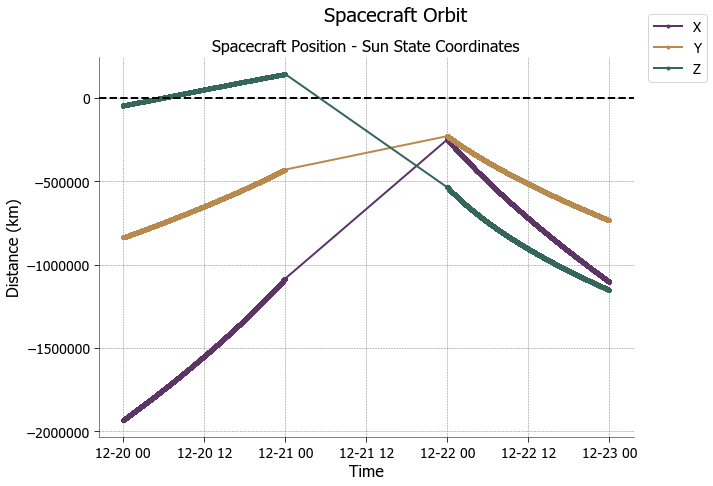

In [12]:
#if we try and plot the spacecraft orbit from this - what would happen? 
#let's try a very simple plot just to see what's going on - 

fig = plt.figure(figsize=(11, 7))
fig.suptitle('Spacecraft Orbit', fontsize=20)

#set up gridspec
gs = plt.GridSpec(1, 1, hspace = 0.3, wspace = 0.0, right = 0.8)

#add subplots
ax2 = fig.add_subplot(gs[0, :])

#remember to convert datetime index to pydatetime for plotting

ax2.plot(data_FGM.index, 
         data_FGM['POS_X'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')

ax2.plot(data_FGM.index, 
         data_FGM['POS_Y'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')

ax2.plot(data_FGM.index, 
         data_FGM['POS_Z'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Distance (km)', fontsize = 16)
ax2.set_xlabel('Time', fontsize = 16)

ax2.legend(bbox_to_anchor = (1.15, 1.13), prop={'size':14})

#setting labeling
ax2.set_title('Spacecraft Position - Sun State Coordinates',   fontsize = 16)


ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')


### Discussion Time - 

### How would you interpret this plot? Secondarily, what happened with our DOY 355 missing data? How did `matplotlib` plot this?

In [13]:
#
##
###
####
#####
####
###
##
#
##
###
####
#####
####
###
##
#
##
###
####
#####
####
###
##
#


## *Part 3. B Missing Data and Plotting - Cleaning Up*

It would be useful 1) to have this in Jupiter Radii, 2) to fill in the missing data in the dataframe, and 3) a clear break between the lines rather than continous. 

We have some functions in the external functions written to help us do this. 

Use the `help()` command to find a function that might be helpful to convert to Jupiter Radii below.

In [14]:
#write help function here

help(extfunc)


Help on module externalfunctions:

NAME
    externalfunctions - externalfunctions.py

DESCRIPTION
    Comment Block for external modules should have: 
    
    Name and Date: 
    - Written on 1/29/2018 for CLaSP 405 by Lab TA A. Azari. 
    
    Purpose:
    - To create a module with helpful reading file functions and 
    magnetic field data analysis for Lab 4.

FUNCTIONS
    add_quadrature(X, Y, Z)
        Calculates a quadrature sum of three values. 
        Formula as np.sqrt(x^2 + y^2 + z^2)
        Useful when calculating the  magnitude of X, Y, Z vector components. 
        
        Inputs:
        - X, array or single value (numpy etc).
        - Y, array or single value (numpy etc).
        - Z, array or single value (numpy etc).
        
        Outputs:
        - magnitude, array or single value (numpy etc) of magnitude of components.
    
    convert_jupiter_r(columns)
        Takes in a dataframe subset and converts
        into radii of Jupiter by creating new columns.
 


-

-

-

-

-



### Converting to Jupiter Radii

Let's use the function we saw to convert out radius values. 

In [15]:
#pass in columns to convert
converted_cols = extfunc.convert_jupiter_r(data_FGM[['POS_X', 'POS_Y', 'POS_Z']])

#create and assign new columns here - 
data_FGM[['POS_X_RJ', 'POS_Y_RJ', 'POS_Z_RJ']] = converted_cols

#take a look 
print(data_FGM[['POS_X_RJ', 'POS_X']].head())

                      POS_X_RJ        POS_X
DATETIME                                   
2018-12-20 00:00:00 -27.034293 -1932735.650
2018-12-20 00:00:01 -27.034228 -1932731.022
2018-12-20 00:00:02 -27.034113 -1932722.793
2018-12-20 00:00:03 -27.033998 -1932714.565
2018-12-20 00:00:04 -27.033883 -1932706.337


### ReSampling to Adjust for Missing Data

The magnetic field data has missing values. Let's learn some useful effects of having a datetime index.



In [16]:
#this command resamples our array at the 1S frequency ie it adds in values where there are 
#missing values and fills with NAN

one_second_data_FGM = (data_FGM.resample('1S').asfreq())


#And now let's check the lengths again -

print(len(one_second_data_FGM), (24*3*60*60), len(data_FGM))


259200 259200 172195


In [17]:
#making sure this took hold - 

#print out values
print(one_second_data_FGM.loc[dt.datetime(2018, 12, 21, 1), :])
print(one_second_data_FGM.loc[dt.datetime(2018, 12, 22, 1), :])




DATETIME    NaN
MSEC        NaN
B_X         NaN
B_Y         NaN
B_Z         NaN
POS_X       NaN
POS_Y       NaN
POS_Z       NaN
POS_X_RJ    NaN
POS_Y_RJ    NaN
POS_Z_RJ    NaN
Name: 2018-12-21 01:00:00, dtype: object
DATETIME    2018 356 1 0 0
MSEC                   503
B_X                 455.06
B_Y                 438.33
B_Z                 463.81
POS_X              -293649
POS_Y              -256860
POS_Z              -576031
POS_X_RJ          -4.10745
POS_Y_RJ          -3.59285
POS_Z_RJ          -8.05728
Name: 2018-12-22 01:00:00, dtype: object


### This is a powerful tool of our analysis that we just found. We can now deal with poorly formatted data, missing data etc. What questions do you have on re-sampling?

#### *Part 3. C Example Plot of Newly Resampled Data 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


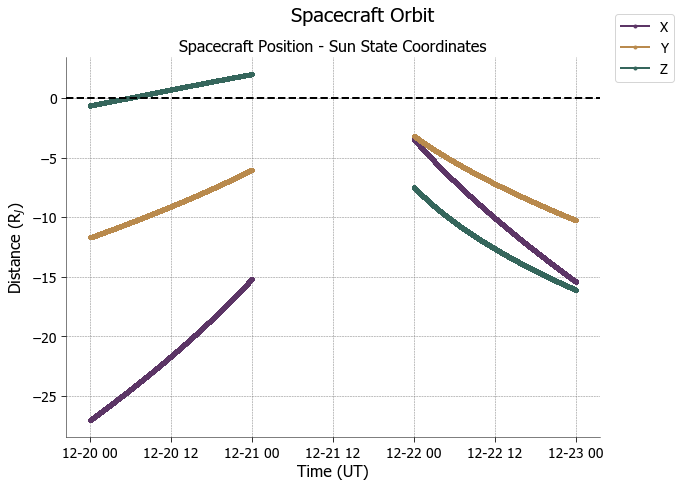

In [18]:
fig = plt.figure(figsize=(11, 7))
fig.suptitle('Spacecraft Orbit', fontsize=20)

#set up gridspec
gs = plt.GridSpec(1, 1, hspace = 0.3, wspace = 0.0, right = 0.8)

#add subplots
ax2 = fig.add_subplot(gs[0, :])



#THIS IS NEW --------------------------------------------------------
ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')
             
ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')
             
ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Z_RJ'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')
#THIS IS NEW --------------------------------------------------------

#set up axhline location
ax2.axhline(y=0.0, color = 'k', linestyle = '--')

ax2.set_ylabel('Distance (R$_{J}$)', fontsize = 16)
ax2.set_xlabel('Time (UT)', fontsize = 16)

ax2.legend(bbox_to_anchor = (1.15, 1.13), prop={'size':14})

#setting labeling
ax2.set_title('Spacecraft Position - Sun State Coordinates',   fontsize = 16)


ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')

### Notice how the np.nan values in the array or the missing date value are no longer being plotted? Also the distance axis is now in Jupiter radii? 


### Do we like the time cadence and axis labeling of this?


# Part 4 - Plotting Different Datetime Formatter Objects / Major & Minor Axis

So far we haven't adjusted the auto choice of Python for plotting axis labels. In this section we learn how to accomplish this for both datetime and non-datetime axes. 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


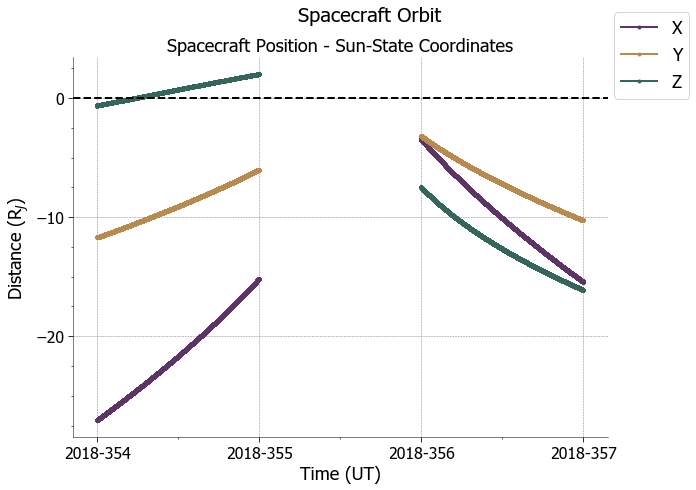

In [19]:
fig = plt.figure(figsize=(11, 7))
fig.suptitle('Spacecraft Orbit', fontsize=20)

gs = plt.GridSpec(1, 1, hspace = 0.3, wspace = 0.0, right = 0.8)

#add subplots
ax2 = fig.add_subplot(gs[0, :])


ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Z_RJ'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Distance (R$_{J}$)', fontsize = 18)

#setting labeling
ax2.set_title('Spacecraft Position - Sun-State Coordinates',   fontsize = 18)

ax2.tick_params(labelsize = 16)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')

#THIS IS NEW----------------------------------------------------------------

#This sets a minor locator object every 2.5, and a major one every 10 - it sets up
#the yaxis to have ticks at the minor cadence and labels at the major one
ax2.yaxis.set_minor_locator(MultipleLocator(2.5))
ax2.yaxis.set_major_locator(MultipleLocator(10))

#what about datetime objects? You can do a similar thing with this syntax
ax2.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax2.xaxis.set_major_locator(mdt.DayLocator())

#This is then useful because you can set the format
ax2.xaxis.set_major_formatter(mdt.DateFormatter('%Y-%j'))
ax2.set_xlabel('Time (UT)', fontsize = 18)
ax2.legend(bbox_to_anchor = (1.17, 1.141), prop={'size':18});
#----------------------------------------------------------------

### What do you think about this one? 

# Part 5 - Plotting Magnetic Field Data

Let's go ahead and start plotting the magnetic field data as well. 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


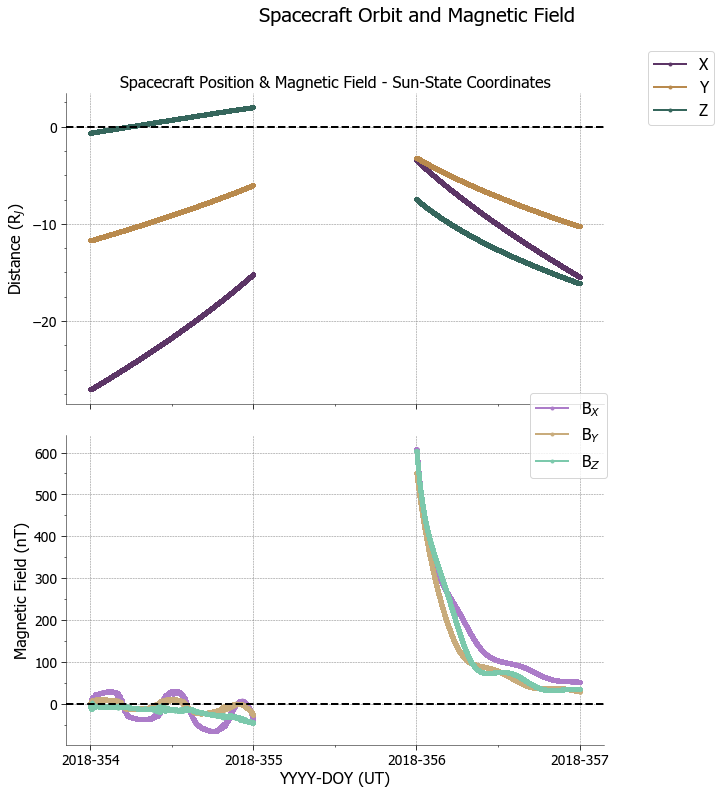

In [20]:
fig = plt.figure(figsize=(13, 12))
fig.suptitle('Spacecraft Orbit and Magnetic Field', fontsize=20)


gs = plt.GridSpec(2, 1, hspace = 0.1, wspace = 0.0, right = 0.7)

#add subplots
ax2 = fig.add_subplot(gs[0, :])
ax3 = fig.add_subplot(gs[1, :])


ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Z_RJ'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Distance (R$_{J}$)', fontsize = 16)


#setting labeling
ax2.set_title('Spacecraft Position & Magnetic Field - Sun-State Coordinates', fontsize = 16)


ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')
ax2.set_xticklabels([])


ax2.yaxis.set_minor_locator(MultipleLocator(2.5))
#minor will have grid ticks
ax2.yaxis.set_major_locator(MultipleLocator(10))
#major will default to grid AND labels
#behaivor can be programmed


ax3.yaxis.set_minor_locator(MultipleLocator(50))
#minor will have grid ticks
ax3.yaxis.set_major_locator(MultipleLocator(100))
#major will default to grid AND labels
#behaivor can be programmed

ax2.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax2.xaxis.set_major_locator(mdt.DayLocator())

ax3.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax3.xaxis.set_major_locator(mdt.DayLocator())
#SET FORMAT
ax3.xaxis.set_major_formatter(mdt.DateFormatter('%Y-%j'))

#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_X'], 
         marker = '.', 
         color = '#ac7cc9', 
         label = 'B$_{X}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Y'], 
         marker = '.', 
         color = '#c9ac7c', 
         label = 'B$_{Y}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Z'], 
         marker = '.', 
         color = '#7cc9ac', 
         label = 'B$_{Z}$')

ax3.axhline(y=0.0, color = 'k', linestyle = '--')
ax3.set_ylabel('Magnetic Field (nT)', fontsize = 16)
ax3.set_xlabel('YYYY-DOY (UT)', fontsize = 16)

ax2.legend(bbox_to_anchor = (1.22, 1.16), prop={'size':16})
ax3.legend(bbox_to_anchor = (1.02, 1.16), prop={'size':16})

ax3.tick_params(labelsize = 14)
#set up the grid
ax3.grid(color = 'gray', linestyle = 'dashed')

### What do we think of this plot? Would it be useful to have the orbit as a non-line plot? Perhaps as text?



## Adding in 2D Orbital Trajectory 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


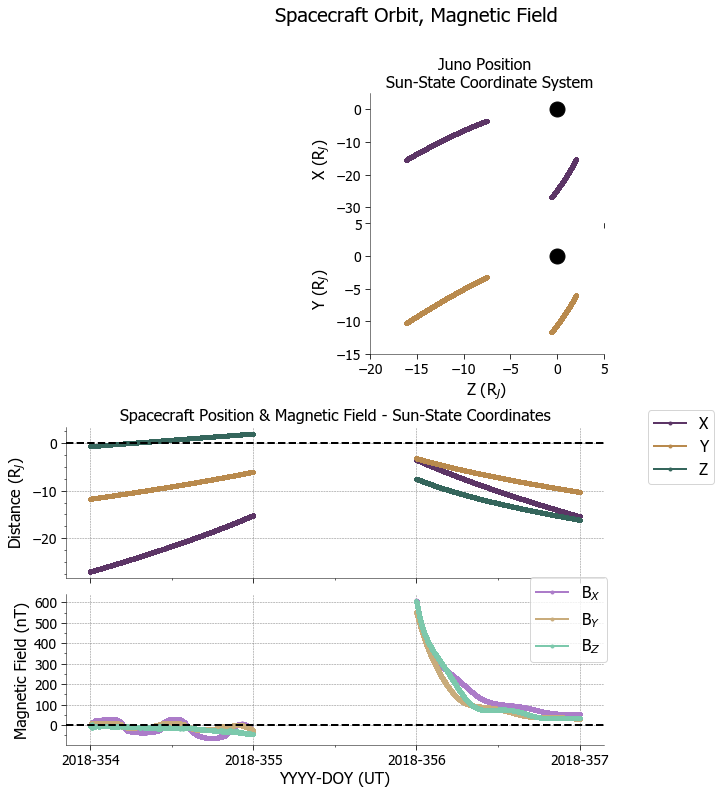

In [21]:
fig = plt.figure(figsize=(13, 12))
fig.suptitle('Spacecraft Orbit, Magnetic Field', fontsize=20)


gs_bottom = plt.GridSpec(4, 1, hspace = 0.1, wspace = 0.0, right = 0.7)
gs_top = plt.GridSpec(5, 2, hspace = 0.0, wspace = 0.3, right = 0.7)

#add subplots
ax2 = fig.add_subplot(gs_bottom[2, :])
ax3 = fig.add_subplot(gs_bottom[3, :])
ax4 = fig.add_subplot(gs_top[0, 1])
ax5 = fig.add_subplot(gs_top[1, 1])

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Z_RJ'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Distance (R$_{J}$)', fontsize = 16)


#setting labeling
ax2.set_title('Spacecraft Position & Magnetic Field - Sun-State Coordinates', fontsize = 16)



ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')
ax2.set_xticklabels([])


ax2.yaxis.set_minor_locator(MultipleLocator(2.5))
#minor will have grid ticks
ax2.yaxis.set_major_locator(MultipleLocator(10))
#major will default to grid AND labels
#behaivor can be programmed


ax3.yaxis.set_minor_locator(MultipleLocator(50))
#minor will have grid ticks
ax3.yaxis.set_major_locator(MultipleLocator(100))
#major will default to grid AND labels
#behaivor can be programme



#what about datetime objects?

ax2.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax2.xaxis.set_major_locator(mdt.DayLocator())

ax3.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax3.xaxis.set_major_locator(mdt.DayLocator())
#SET FORMAT
ax3.xaxis.set_major_formatter(mdt.DateFormatter('%Y-%j'))
ax3.set_xlabel('Time (UT)', fontsize = 18)

#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')


ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_X'], 
         marker = '.', 
         color = '#ac7cc9', 
         label = 'B$_{X}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Y'], 
         marker = '.', 
         color = '#c9ac7c', 
         label = 'B$_{Y}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Z'], 
         marker = '.', 
         color = '#7cc9ac', 
         label = 'B$_{Z}$')

ax4.plot(one_second_data_FGM['POS_Z_RJ'], 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566')

ax5.plot(one_second_data_FGM['POS_Z_RJ'], 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d')

#x-values
#plot out location of Jupiter
ax4.set_title('Juno Position \n Sun-State Coordinate System', fontsize = 16)
ax4.plot([0], [0], color='k', marker = 'o',  markersize = 15)
ax5.plot([0], [0], color='k', marker = 'o',  markersize = 15)

ax4.set_ylim([-35, 5])
ax5.set_ylim([-15, 5])

ax4.set_xticklabels([])

ax4.set_xlim([-20, 5])
ax5.set_xlim([-20, 5])

ax4.grid()
ax5.grid()

ax4.tick_params(labelsize = 14)
ax5.tick_params(labelsize = 14)

ax4.set_ylabel('X (R$_{J}$)', fontsize = 16)
ax5.set_xlabel('Z (R$_{J}$)', fontsize = 16)
ax5.set_ylabel('Y (R$_{J}$)', fontsize = 16)


ax3.axhline(y=0.0, color = 'k', linestyle = '--')
ax3.set_ylabel('Magnetic Field (nT)', fontsize = 16)
ax3.set_xlabel('YYYY-DOY (UT)', fontsize = 16)

ax2.legend(bbox_to_anchor = (1.22, 1.16), prop={'size':16})
ax3.legend(bbox_to_anchor = (1.02, 1.16), prop={'size':16})

ax3.tick_params(labelsize = 14)
#set up the grid
ax3.grid(color = 'gray', linestyle = 'dashed')

# Part 6 - Plotting the Magnitude and the Error

Go ahead and check out the external function file again - if we want to calculate the magnitude of B is there a function that's useful in there? 

-

-

-

-

-

-





In [22]:

#Calculate the magntitude of vector

#B_mag =  adding in quadrature (sqrt(Bx^2 + By^2 + Bz^2))
magnitude = extfunc.add_quadrature(one_second_data_FGM['B_X'], 
                                   one_second_data_FGM['B_Y'], one_second_data_FGM['B_Z'])

one_second_data_FGM['B_MAG'] = magnitude

## Calculating and Plotting Error -  

What if we want the error on the magnitude? In reality the resolution of the Juno FGM is +/- 0.05 nT for measurements under 1600 nT. If we try and look at that error, it won't show on the plot. This is part of the reason the error wasn't in the file we downloaded. 

However, it was noticed that during the flyby of Earth, the largest error recorded was 7 nT, due to attitude error. 

Source: [Connerney et al. 2017](https://link.springer.com/article/10.1007/s11214-017-0334-z)

For the purpose of this lab, let's pretend the resolution is +/- 50 nT. We can calculate the error of a function of several variables as follows:

$$\delta{q} = \sqrt{\Bigl(\frac{\partial q}{\partial x}\delta{x}\Bigl)^2 + 
            \Bigl(\frac{\partial q}{\partial y}\delta{y}\Bigl)^2 + 
            \Bigl(\frac{\partial q}{\partial z}\delta{z}\Bigl)^2}$$

In this particular case, each component is as follows by taking the partial derivative.

$$\Bigl(\frac{\partial q}{\partial x} \Bigl) = \frac{B_{x}}{\lvert B \rvert}$$

... and similarly for y and z

$$\Bigl(\frac{\partial q}{\partial y} \Bigl) = \frac{B_{y}}{\lvert B \rvert},  \Bigl(\frac{\partial q}{\partial z} \Bigl) = \frac{B_{z}}{\lvert B \rvert}$$

Let's now calculate each respective piece and then again use our extfunc module to add in quadrature.

In [23]:
#Warning the resolution is adjusted to a larger quantity for the sole purpose of this lab - 

resolution = 50.0 #nT

error_x = (one_second_data_FGM['B_X'] / one_second_data_FGM['B_MAG']) * resolution
error_y = (one_second_data_FGM['B_Y'] / one_second_data_FGM['B_MAG']) * resolution
error_z = (one_second_data_FGM['B_Z'] / one_second_data_FGM['B_MAG']) * resolution

magnitude_error = extfunc.add_quadrature(error_x, error_y, error_z)

one_second_data_FGM['B_MAG_ERROR'] = magnitude_error

#and now what? Lets go ahead and plot again with error


## Final -  Field Plot with Error

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


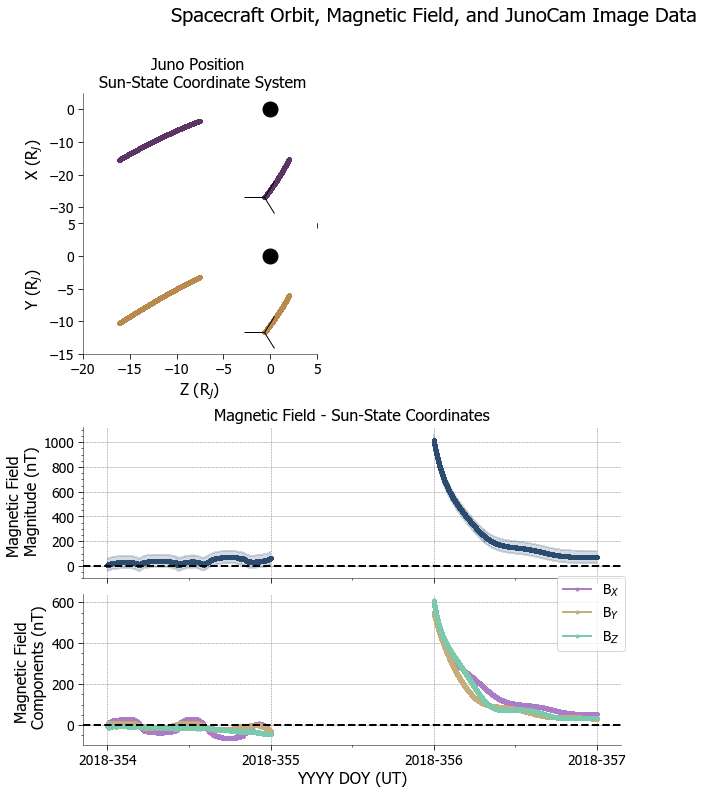

In [24]:
fig = plt.figure(figsize=(13, 12))
fig.suptitle('Spacecraft Orbit, Magnetic Field, and JunoCam Image Data', fontsize=20)

gs_top  = plt.GridSpec(5, 2, hspace=0, wspace=0.3, right=0.7)
gs_bottom = plt.GridSpec(4, 1, hspace=0.1, wspace=0.0, right=0.7)

#add subplots
ax2 = fig.add_subplot(gs_bottom[2, :])
ax3 = fig.add_subplot(gs_bottom[3, :])
ax4 = fig.add_subplot(gs_top[0, 0])
ax5 = fig.add_subplot(gs_top[1, 0])


ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_MAG'], 
         marker = '.', 
         color = '#2b4c6e', 
         label = 'B$_{Magnitude}$')

ax2.fill_between(one_second_data_FGM.index, 
                 one_second_data_FGM['B_MAG'] - one_second_data_FGM['B_MAG_ERROR'], 
                 one_second_data_FGM['B_MAG_ERROR'] + one_second_data_FGM['B_MAG'], 
                 alpha = 0.2, 
                 color = '#2b4c6e')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')



#setting labeling
ax2.set_title('Magnetic Field - Sun-State Coordinates', fontsize = 16)


ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')
ax2.set_xticklabels([])


ax2.yaxis.set_minor_locator(MultipleLocator(50))
#minor will have grid ticks
ax2.yaxis.set_major_locator(MultipleLocator(200))
#major will default to grid AND labels
#behaivor can be programmed


ax3.yaxis.set_minor_locator(MultipleLocator(50))
#minor will have grid ticks
ax3.yaxis.set_major_locator(MultipleLocator(200))

ax2.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax2.xaxis.set_major_locator(mdt.DayLocator())

ax3.xaxis.set_minor_locator(mdt.HourLocator(np.arange(0, 24, 12)))
ax3.xaxis.set_major_locator(mdt.DayLocator())

#SET FORMAT
ax3.xaxis.set_major_formatter(mdt.DateFormatter('%Y-%j'))
ax3.set_xlabel('YYYY DOY (UT)', fontsize = 18)

#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')


ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_X'], 
         marker = '.', 
         color = '#ac7cc9', 
         label = 'B$_{X}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Y'], 
         marker = '.', 
         color = '#c9ac7c', 
         label = 'B$_{Y}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Z'], 
         marker = '.', 
         color = '#7cc9ac', 
         label = 'B$_{Z}$')

ax4.plot(one_second_data_FGM['POS_Z_RJ'], 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566')

ax5.plot(one_second_data_FGM['POS_Z_RJ'], 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d')

#make start of spacecraft location obvious
ax4.plot(one_second_data_FGM['POS_Z_RJ'].iat[0], 
         one_second_data_FGM['POS_X_RJ'].iat[0], 
         marker='3', 
         color='k', 
         markersize=40)

ax5.plot(one_second_data_FGM['POS_Z_RJ'].iat[0], 
         one_second_data_FGM['POS_Y_RJ'].iat[0], 
         marker='3', 
         color='k', 
         markersize=40, 
         label = 'S/C Starting Location')

#x-values
#plot out location of Jupiter
ax4.set_title('Juno Position \n Sun-State Coordinate System', fontsize = 16)
ax4.plot([0], [0], color='k', marker = 'o',  markersize = 15)
ax5.plot([0], [0], color='k', marker = 'o',  markersize = 15)



ax4.set_ylim([-35, 5])
ax5.set_ylim([-15, 5])

ax4.set_xticklabels([])

ax4.set_xlim([-20, 5])
ax5.set_xlim([-20, 5])

ax4.grid()
ax5.grid()

ax4.tick_params(labelsize = 14)
ax5.tick_params(labelsize = 14)

ax4.set_ylabel('X (R$_{J}$)', fontsize = 16)
ax5.set_xlabel('Z (R$_{J}$)', fontsize = 16)
ax5.set_ylabel('Y (R$_{J}$)', fontsize = 16)


ax3.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Magnetic Field \n Magnitude (nT)', fontsize = 16)
ax3.set_ylabel('Magnetic Field \n Components (nT)',      fontsize = 16)
ax3.set_xlabel('YYYY DOY (UT)', fontsize = 16)



ax3.legend(bbox_to_anchor = (1.02, 1.16), prop={'size':14})


ax3.tick_params(labelsize = 14)
#set up the grid
ax3.grid(color = 'gray', linestyle = 'dashed')

#savefigure
plt.savefig('./Images/JunoCam_MagData_{:%Y-%j-%H-%M}.png'.format(one_second_data_FGM.index[0]), 
            dpi=300, bbox_inches='tight')

### What do you think the stripes are in the error for the magnitude of B plot? Also in this case did it make sense to do the full error calculation? 

# SUMMARY

From this lab you have learned the basics of missing data, field vector analysis, and merging error analysis into Python plots. Additionally you have learned about self written modules. 


-

-

-

-

-

-

## *EXTRA - Adding Orbital Parameters As Text*

With a moving observation it's good to keep track of your location. We saw one way to do this on the previous plots, what about with additional text labels?

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


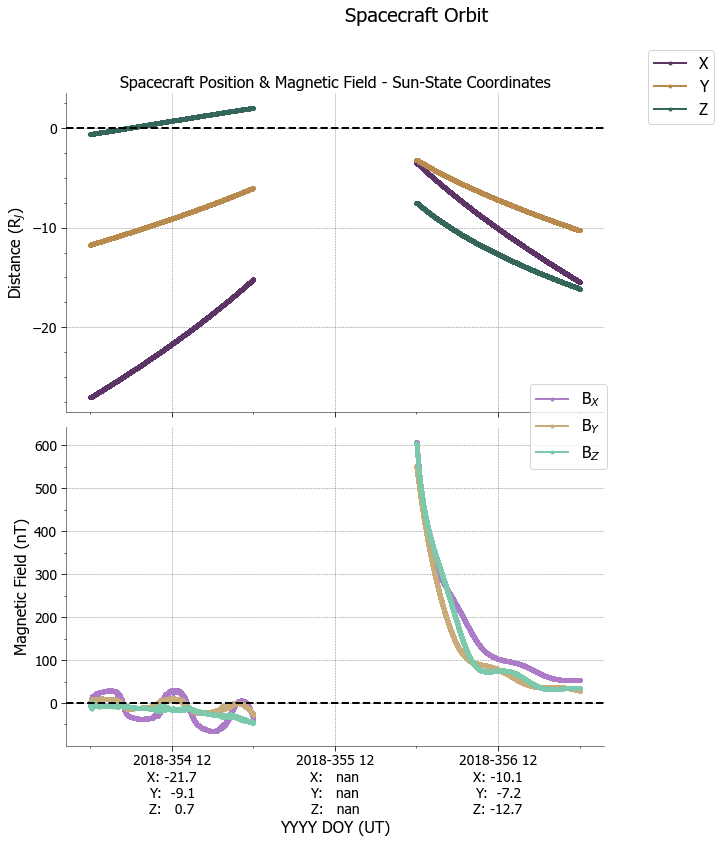

In [25]:
fig = plt.figure(figsize=(13, 12))
fig.suptitle('Spacecraft Orbit', fontsize=20)

gs_bottom = plt.GridSpec(4, 1, hspace = 0.1, wspace = 0.0, right = 0.7)

#add subplots
ax2 = fig.add_subplot(gs_bottom[0:2, :])
ax3 = fig.add_subplot(gs_bottom[2:, :])

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_X_RJ'], 
         marker = '.', 
         color = '#5c3566', 
         label = 'X')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Y_RJ'], 
         marker = '.', 
         color = '#b98a4d', 
         label = 'Y')

ax2.plot(one_second_data_FGM.index, 
         one_second_data_FGM['POS_Z_RJ'], 
         marker = '.', 
         color = '#35665c', 
         label = 'Z')

ax2.axhline(y=0.0, color = 'k', linestyle = '--')
ax2.set_ylabel('Distance (R$_{J}$)', fontsize = 16)


#setting labeling
ax2.set_title('Spacecraft Position & Magnetic Field - Sun-State Coordinates', fontsize = 16)


ax2.tick_params(labelsize = 14)
#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')
ax2.set_xticklabels([])


ax2.yaxis.set_minor_locator(MultipleLocator(2.5))
#minor will have grid ticks
ax2.yaxis.set_major_locator(MultipleLocator(10))
#major will default to grid AND labels
#behaivor can be programmed



# ---------------------------------------------------------------------------------- #
# function formatter; makes custom labels
def juno_pos_fmttr(tick_val, tick_pos):
    '''
    matplotlib formatter for custom position and time labels
    
    to use: pass this function without args to a set_major_formatter()
            or set_minor_formatter() method of an axis object
    '''
    
    datetime_of_tick = mdt.num2date(tick_val)
    
    
    x_pos = one_second_data_FGM.loc[datetime_of_tick, 'POS_X_RJ'] 
    y_pos = one_second_data_FGM.loc[datetime_of_tick, 'POS_Y_RJ']
    z_pos = one_second_data_FGM.loc[datetime_of_tick, 'POS_Z_RJ']
        
    
    format_string = '{3:%Y-%j %H}\nX:{0: 6.1f}\nY:{1: 6.1f}\nZ:{2: 6.1f}'.format(
                    x_pos, y_pos, z_pos, datetime_of_tick)
    
    return format_string
    
# ---------------------------------------------------------------------------------- #
    




ax3.yaxis.set_minor_locator(MultipleLocator(50))
#minor will have grid ticks
ax3.yaxis.set_major_locator(MultipleLocator(100))
#major will default to grid AND labels
#behaivor can be programmed

ax2.xaxis.set_major_locator(mdt.HourLocator(12))
ax2.xaxis.set_minor_locator(mdt.DayLocator())
ax3.xaxis.set_major_locator(mdt.HourLocator(12))
ax3.xaxis.set_minor_locator(mdt.DayLocator())


#SET FORMAT
ax3.xaxis.set_major_formatter(FuncFormatter(juno_pos_fmttr))

#set up the grid
ax2.grid(color = 'gray', linestyle = 'dashed')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_X'], 
         marker = '.', 
         color = '#ac7cc9', 
         label = 'B$_{X}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Y'], 
         marker = '.', 
         color = '#c9ac7c', 
         label = 'B$_{Y}$')

ax3.plot(one_second_data_FGM.index, 
         one_second_data_FGM['B_Z'], 
         marker = '.', 
         color = '#7cc9ac', 
         label = 'B$_{Z}$')

ax3.axhline(y=0.0, color = 'k', linestyle = '--')
ax3.set_ylabel('Magnetic Field (nT)', fontsize = 16)
ax3.set_xlabel('YYYY DOY (UT)', fontsize = 16)

ax2.legend(bbox_to_anchor = (1.22, 1.16), prop={'size':16})
ax3.legend(bbox_to_anchor = (1.02, 1.16), prop={'size':16})

ax3.tick_params(labelsize = 14)
#set up the grid
ax3.grid(color = 'gray', linestyle = 'dashed')